In [65]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
from scipy.stats import skew
from scipy import stats
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

In [66]:
# Loading the dataset from a CSV file
df=pd.read_csv("Fragrance_Dataset_COM7022_4037.csv") 

# Creating a backup of the original DataFrame
df_backup = df.copy()

<h1>Data Understanding


In [67]:
# Checking the structure and data types of the dataset (column data types and non-null counts)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              999 non-null    object 
 1   title              1000 non-null   object 
 2   type               997 non-null    object 
 3   price              996 non-null    float64
 4   priceWithCurrency  1000 non-null   object 
 5   available          889 non-null    float64
 6   availableText      997 non-null    object 
 7   sold               994 non-null    float64
 8   lastUpdated        947 non-null    object 
 9   itemLocation       1000 non-null   object 
dtypes: float64(3), object(7)
memory usage: 78.3+ KB


In [68]:
# Showing the first few rows of the dataset (sample records to understand dataset content)
df.head() 

,brand,title,type,price,priceWithCurrency,available,availableText,sold,lastUpdated,itemLocation
0,Dior,Christian Dior Sauvage Men's EDP 3.4 oz Fragra...,Eau de Parfum,84.99,US $84.99/ea,10.0,More than 10 available / 116 sold,116.0,"May 24, 2024 10:03:04 PDT","Allen Park, Michigan, United States"
1,AS SHOW,A-v-entus Eau de Parfum 3.3 oz 100ML Millesime...,Eau de Parfum,109.99,US $109.99,8.0,8 available / 48 sold,48.0,"May 23, 2024 23:07:49 PDT","Atlanta, Georgia, Canada"
2,Unbranded,HOGO BOSS cologne For Men 3.4 oz,Eau de Toilette,100.00,US $100.00,10.0,More than 10 available / 27 sold,27.0,"May 22, 2024 21:55:43 PDT","Dearborn, Michigan, United States"
3,Giorgio Armani,Acqua Di Gio by Giorgio Armani 6.7 Fl oz Eau D...,Eau de Toilette,NaN,US $44.99/ea,2.0,2 available / 159 sold,159.0,"May 24, 2024 03:30:43 PDT","Reinholds, Pennsylvania, United States"
4,Lattafa,Lattafa Men's Hayaati Al Maleky EDP Spray 3.4 ...,Fragrances,16.91,US $16.91,NaN,Limited quantity available / 156 sold,156.0,"May 24, 2024 07:56:25 PDT","Brooklyn, New York, United States"


In [69]:
# Getting statistical summary of the DataSet ((mean, std, min, max, etc.))
df.describe()

,price,available,sold
count,996.000000,889.000000,994.000000
mean,46.497279,20.046119,766.266600
std,35.590865,61.547985,3200.971733
min,3.000000,2.000000,1.000000
25%,22.990000,5.000000,14.000000
50%,35.710000,10.000000,49.500000
75%,59.000000,10.000000,320.500000
max,259.090000,842.000000,54052.000000


In [70]:
# Detecting the number of missing values in each column
print ("<<< The number of missing values in each column >>>\n ")
print(df.isnull().sum())
print("The total number of missing values ----> ", df.isnull().sum().sum())

# Checking duplicate 
duplicates = df.duplicated()
print("\nThe number of duplicate rows ----------> ", duplicates.sum())

# Finding the number of unique data for each column
print ("\n<<< The number of unique data for each column >>>\n")
print(df.apply(lambda x: x.astype(str).str.lower().nunique()))


<<< The number of missing values in each column >>>
 
brand                  1
title                  0
type                   3
price                  4
priceWithCurrency      0
available            111
availableText          3
sold                   6
lastUpdated           53
itemLocation           0
dtype: int64
The total number of missing values ---->  181

The number of duplicate rows ---------->  0

<<< The number of unique data for each column >>>

brand                229
title                964
type                  53
price                601
priceWithCurrency    685
available             90
availableText        759
sold                 429
lastUpdated          934
itemLocation         274
dtype: int64


<h1>Preprocessing

<h2>Filling missing values using constant values or based on related columns


In [71]:
# Filling a null value in the 'brand' column with "Versace" (according the content of 'title' column)

df.loc[df['brand'].isna(), 'brand'] = "Versace"

# Count the number of null values before filling
print("Before:", df_backup['brand'].isna().sum())

# Count the number of null values after filling
print("After:", df['brand'].isna().sum())

Before: 1
After: 0


In [72]:
# Filling two null values in the 'type' column  with "Eau de Parfum" (according the content of 'title' column)

df.loc[df['type'].isna(), 'type'] = "Eau de Parfum"
df.loc[df['type'].isna() | (df['type'] == 'y') | (df['type'] == '\\'), 'type'] = "Eau de Parfum"


# Count the number of null values before filling
print("Before:", df_backup['type'].isna().sum())

# Count the number of null values after filling
print("After:", df['type'].isna().sum())


Before: 3
After: 0


In [73]:
# Filling null values in the 'Price' column with the content of 'priceWithCurrency' column
import re

# Function to extract a numeric value from priceWithCurrency
def extract_price_resilient(s):
    if pd.isna(s):
        return np.nan
    # Removing '/ea' and extra whitespace
    s = s.replace('/ea', '').strip()
    # Searching for the first decimal or integer number in the string
    match = re.search(r'(\d+\.?\d*)', s)
    if match:
        return float(match.group(1))
    return np.nan

# Filling null values in 'price' column with extracted numbers from 'priceWithCurrency'
df['price'] = df['price'].fillna(df['priceWithCurrency'].apply(extract_price_resilient))

# Count the number of null values before filling
print("Before:", df_backup['price'].isna().sum())

# Count the number of null values after filling
print("After:", df['price'].isna().sum())

Before: 4
After: 0


In [74]:
# Filling null values in the 'available' column according the content of 'availableText' column

mask = df['available'].isna() # Only check rows where 'available' is null

# If the text contains "Last One" → set available = 1
df.loc[mask & df['availableText'].str.contains("Last One", na=False), 'available'] = 1

# If the text contains "Limited quantity available" → set available = 3
df.loc[mask & df['availableText'].str.contains("Limited quantity available", na=False), 'available'] = 3

# Count the number of null values before filling
print("Before:", df_backup['available'].isna().sum())

# Count the number of null values after filling
print("After:", df['available'].isna().sum())

Before: 111
After: 5


In [75]:
# Filling null values in the 'lastUpdated' column with 'unknown'
df['lastUpdated'] = df['lastUpdated'].fillna('unknown')

# Count the number of null values before filling
print("Before:", df_backup['lastUpdated'].isna().sum())

# Count the number of null values after filling
print("After:", df['lastUpdated'].isna().sum())

Before: 53
After: 0


In [76]:
# Dropping rows with missing values (NaN)
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 992 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              992 non-null    object 
 1   title              992 non-null    object 
 2   type               992 non-null    object 
 3   price              992 non-null    float64
 4   priceWithCurrency  992 non-null    object 
 5   available          992 non-null    float64
 6   availableText      992 non-null    object 
 7   sold               992 non-null    float64
 8   lastUpdated        992 non-null    object 
 9   itemLocation       992 non-null    object 
dtypes: float64(3), object(7)
memory usage: 85.2+ KB


<h2>Checking if Scent Families Can Be Extracted from 'title' or 'type' columns

In [78]:
# Classify perfumes into scent families based on 'title' column 

# Converting all perfume titles to lowercase
df['title_clean'] = df['title'].str.lower() 

# Removing all non-alphabetic characters (numbers, punctuation, symbols, etc.) and keeping only letters and spaces
df['title_clean'] = df['title_clean'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', str(x)))

# Defining a dictionary of perfume families
perfume_families = {
    'citrus': ['citrus', 'lemon', 'bergamot', 'orange', 'mandarin', 'grapefruit','lime', 'tangerine', 
               'neroli', 'yuzu', 'pomelo', 'citron'],
    'floral': ['rose', 'jasmine', 'lavender', 'lily', 'violet', 'peony', 'orchid','tuberose', 'iris', 'gardenia', 
               'magnolia', 'freesia', 'honeysuckle','cherry blossom', 'ylang', 'geranium', 'camelia', 'mimosa'],
    'woody': ['sandalwood', 'cedar', 'patchouli', 'vetiver', 'oud', 'wood','mahogany', 'pine', 'teak', 'birch', 
              'cashmere', 'guaiac', 'cypress','amberwood', 'moss', 'leather', 'tobacco', 'smoke'],
    'oriental': ['amber', 'vanilla', 'musk', 'spice', 'incense', 'resin','benzoin', 'tonka', 'cinnamon', 'clove', 
                 'nutmeg', 'saffron','cardamom', 'ambergris', 'labdanum', 'opoponax'],
    'gourmand': ['chocolate', 'coffee', 'caramel', 'honey', 'vanilla', 'sugar','almond', 'praline', 'tonka', 
                 'biscuit', 'milk', 'cream', 'toffee','cocoa', 'hazelnut', 'cotton candy'],
    'fresh': ['aquatic', 'marine', 'ozone', 'fresh', 'green', 'herbal','mint', 'basil', 'sage', 'thyme', 'grass', 
              'tea', 'cucumber','bamboo', 'leaf', 'lemongrass'],
    'fruity': ['apple', 'berry', 'peach', 'pear', 'plum', 'pineapple','melon', 'mango', 'coconut', 'cherry', 
               'fig', 'blackcurrant','raspberry', 'strawberry', 'grape', 'apricot', 'passionfruit']}

# Defining a function to assign perfume families based on keywords found in the 'title' column
def assign_family(title, family_dict):
    matched_families = []  # A list to store matching families
    # A loop through each family and its list of keywords
    for family, keywords in family_dict.items():
        for kw in keywords:
            if kw in title: # Checking if the keyword appears in the 'title' column
                matched_families.append(family)
                break  
    # If one or more families were matched, return them as a comma-separated string
    if matched_families:
        return ', '.join(matched_families)
    else:return 'unknown'  # If no match was found

# Applying the family function to each perfume title
df['family'] = df['title_clean'].apply(lambda x: assign_family(x, perfume_families))

# Counting the number of perfumes in each family category
family_counts = df['family'].value_counts() 

# Displaying overall category statistics
print("\n<<< Number of perfumes in each family>>>") 
print(family_counts)

# Counting how many rows have the family labeled as 'unknown'
unknown_count = (df['family'] == 'unknown').sum() 

# Calculatting how many perfumes have a valid (known) family
known_count = len(df) - unknown_count 

# Printing summary of categorized vs. uncategorized 
print(f"\nNumber of categorized perfumes: {known_count}")
print(f"Number of uncategorized perfumes (unknown): {unknown_count}")


<<< Number of perfumes in each family>>>
family
unknown               896
fresh                  27
fruity                 18
woody                  18
oriental               13
citrus                  7
woody, fresh            3
woody, oriental         3
woody, fruity           2
oriental, gourmand      1
citrus, fruity          1
floral, fresh           1
floral                  1
citrus, fresh           1
Name: count, dtype: int64

Number of categorized perfumes: 96
Number of uncategorized perfumes (unknown): 896


In [79]:
# all unique types of 'type' column
print ("\n--- << all unique types of 'type' column >> ---\n")
print(df['type'].unique())


--- << all unique types of 'type' column >> ---

['Eau de Parfum' 'Eau de Toilette' 'Fragrances' 'Perfume' '/' 'PARFUM'
 'Parfum' 'Concentrated Uncut Pure Body Oil' 'LE PARFUM' 'Eau De Parfum'
 'Unscented' 'Eau de Cologne' '~ THE ONE EAU DE PARFUM SPRAY ~'
 'EXTRAIT DE PARFUM' 'Eau De Toilette' 'Eau De Parfum Intense' 'Pheromone'
 'Aftershave' 'Fragrance & Perfume' 'Eau de Perfume'
 'Jo Malone Cologne Intense Spray' 'Y' 'Gift Sets'
 'Fragrance Rolling Ball' 'Body Spray' 'Eau de toilette'
 'Eau de Toillette'
 'Eau De Toilette, Eau De Parfum, Eau De Parfum Intense' 'Cologne'
 'le parfum' 'Eau de Toilette Intense'
 'Eau de Cologne Spray, Cologne Spray' 'Extrait De Parfum' 'Fine Cologne'
 'Does not apply' 'EDT' 'Extrait de Parfum' 'Editions Parfums'
 'DIOR HOMME COLOGNE' 'Deodorant' 'De Nuit'
 'Eau de Toilette, Cologne Spray' 'Parfum Intense' 'Eau de Parfum Intense'
 'cologne' 'EAU DE COLOGNE SPRAY' 'Roll On' 'Elixir' 'Various' 'Assorted'
 'Eau de Parfum/ Eau de Toilette' 'Deodorant Body 

In [80]:
# Groupping fragrance types 
# Define a function that assigns each perfume type to a group
def assign_intensity_group(title):
    # Define lists of keywords that represent each intensity level
    light = ['Unscented', 'Deodorant', 'Car Air Freshener', 'Eau de Cologne', 'Fine Cologne',
        'cologne', 'EAU DE COLOGNE SPRAY', 'Eau de Cologne Spray, Cologne Spray', 
        'Body Spray', 'Splash-on', 'Fragrance Body Spray','Deodorant Body Spray', 'Fragrances']
    medium_light = ['Eau de Toilette', 'Eau de Toillette', 'edt', 'EDT','Eau de Toilette, Cologne Spray']
    medium_high = ['Eau de Toilette Intense', 'Fragrance Rolling Ball', 
        'Jo Malone Cologne Intense Spray', 'Eau de Parfum', 
        'Eau De Parfum', 'Eau de Perfume', '~ THE ONE EAU DE PARFUM SPRAY ~', 'De Nuit']
    high = ['Eau De Parfum Intense', 'Eau de Parfum Intense', 'Parfum Intense',
        'Eau de Parfum/ Eau de Toilette', 'PARFUM', 'Parfum', 'Perfume', 
        'le parfum', 'LE PARFUM', 'Editions Parfums', 'EXTRAIT DE PARFUM',
        'Extrait De Parfum', 'Extrait de Parfum', 'Concentrated Uncut Pure Body Oil',
        'Elixir de Parfum', 'Elixir', 'Oil', 'Fragrance Oil', 'Body Oil']
    unknown = ['/', 'Y', 'Fragrance & Perfume', 'Pheromone', 'Gift Sets', 
        'Does not apply', 'DIOR HOMME COLOGNE', 'Various', 'Assorted', 'nan']
    # Matching the input title to the correct intensity group
    if title in light:
        return 'Light'
    elif title in medium_light:
        return 'Medium Light'
    elif title in medium_high:
        return 'Medium-High'
    elif title in high:
        return 'High'
    else:return 'Unknown'  # Default category if no match is found

# Create a new column with the assigned intensity group
df['type_Group'] = df['type'].apply(assign_intensity_group)
# Displaying the number of items in each intensity group
order = ['Light', 'Medium Light', 'Medium-High', 'High', 'Unknown']
counts = df['type_Group'].value_counts()
print("Number of items per intensity group:")
for g in order:
    print(f"{g}: {counts.get(g, 0)}")

Number of items per intensity group:
Light: 102
Medium Light: 449
Medium-High: 316
High: 84
Unknown: 41


<h2>Handling of outliers

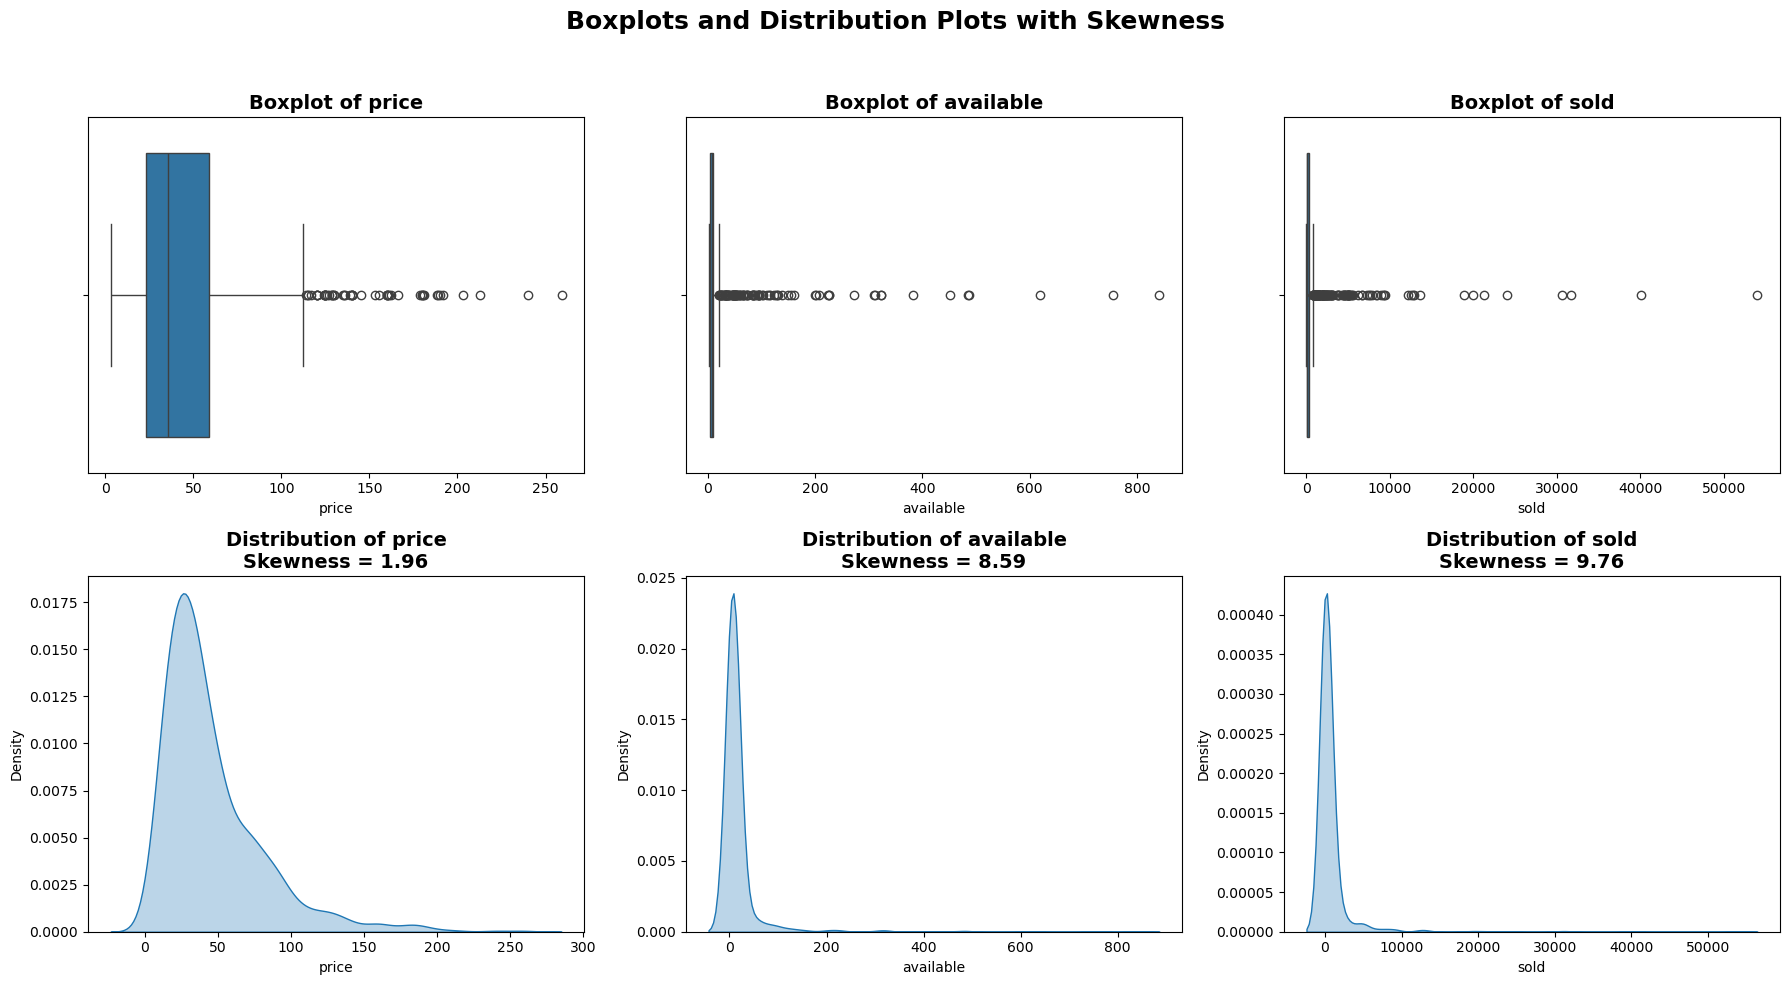

In [81]:
# EDA  Visual graphics (Distribution and Skewness) 
# Checking outliers 
# List of numeric columns to plot
num_cols = ['price', 'available', 'sold']

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# First row: Boxplots
for i, col in enumerate(num_cols):
    ax = axs[0, i]
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(f'Boxplot of {col}', fontsize=14, fontweight='bold')

# Second row: Distribution plots (KDE) with skewness
for i, col in enumerate(num_cols):
    ax = axs[1, i]
    sns.kdeplot(df[col], ax=ax, fill=True, alpha=0.3)
    
    # Calculating skewness
    skewness = skew(df[col])
    
    # Set plot title including skewness value
    ax.set_title(f'Distribution of {col}\nSkewness = {skewness:.2f}', fontsize=14, fontweight='bold')
    ax.set_ylabel('Density')

# Turn off any empty subplots (if number of numeric columns < 3)
for j in range(len(num_cols), 3):
    axs[0, j].axis('off')
    axs[1, j].axis('off')

# Overall figure title
fig.suptitle('Boxplots and Distribution Plots with Skewness', fontsize=18, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


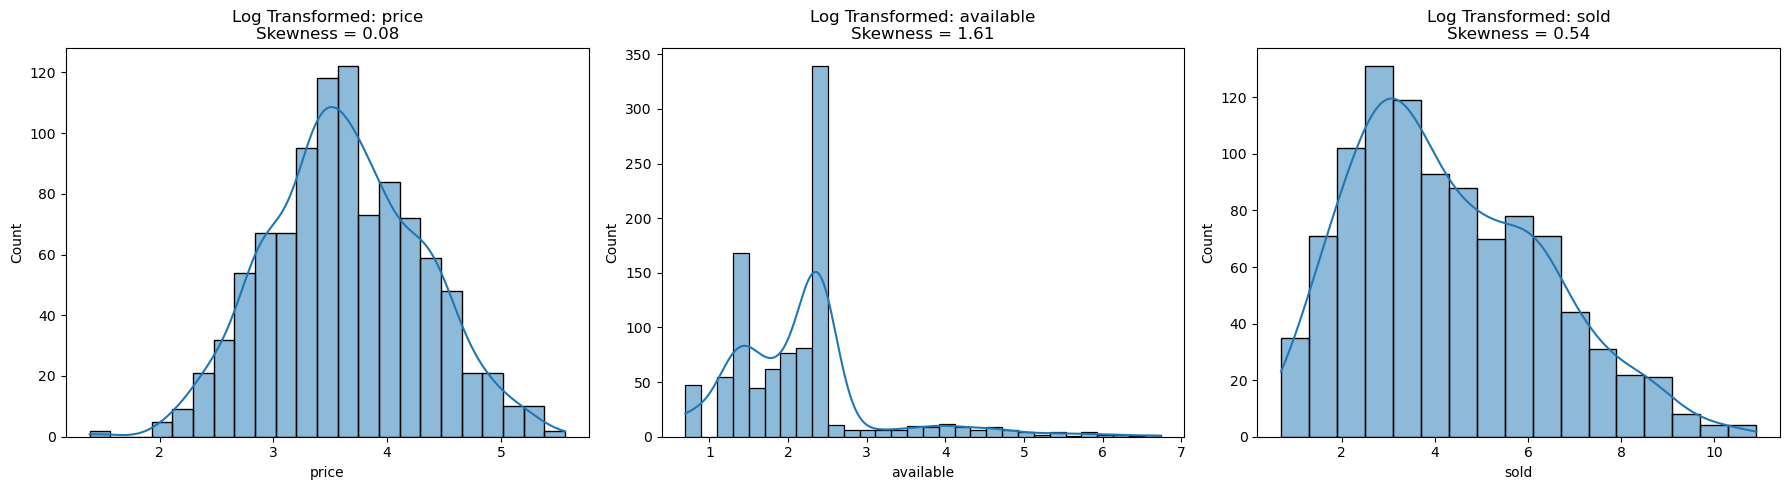

In [82]:
# Applying log transformation to Numeric columns

num_cols = ['price', 'available', 'sold']

# Create log-transformed columns 
for col in num_cols:
    df[f'log_{col}'] = np.log1p(df[col])  

# Plot histograms of the log-transformed columns in one row and three columns
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(num_cols):
    # Plot histogram with KDE for each log-transformed column
    sns.histplot(df[f'log_{col}'], kde=True, ax=axs[i])
    
    # Calculate and display skewness in the plot title
    axs[i].set_title(f'Log Transformed: {col}\nSkewness = {df[f"log_{col}"].skew():.2f}')
    
    # Label x-axis with the original column name
    axs[i].set_xlabel(col)

# Adjust layout to prevent overlapping elements
plt.tight_layout()
plt.show()


In [83]:
# remove outliers using Z-score
def remove_outliers_z(df, cols, threshold=3):
    df_z = df.copy()
    for col in cols:
        z_scores = np.abs(stats.zscore(df_z[col]))
        df_z = df_z[z_scores < threshold]
    return df_z

cols = ['log_price', 'log_available', 'log_sold']
df_z = remove_outliers_z(df, cols)

# Comparing numeric summaries
def summary_stats(df, label):
    print(f"\n<<< Summary for {label}:")
    print(f"Remaining rows: {len(df)}")
    for col in cols:
        print(f"{col}: mean={df[col].mean():.2f}, median={df[col].median():.2f}, skew={df[col].skew():.2f}")
summary_stats(df, "Original Data >>>")
summary_stats(df_z, "After Z-score >>>")


<<< Summary for Original Data >>>:
Remaining rows: 992
log_price: mean=3.63, median=3.61, skew=0.08
log_available: mean=2.16, median=2.20, skew=1.61
log_sold: mean=4.29, median=3.90, skew=0.54

<<< Summary for After Z-score >>>:
Remaining rows: 965
log_price: mean=3.64, median=3.61, skew=0.13
log_available: mean=2.08, median=2.20, skew=0.95
log_sold: mean=4.19, median=3.83, skew=0.52


<h2>Encoding Categorical Columns

In [84]:
#Encoding Categorical Columns into Numeric Values
df = df_z.copy()
# Import LabelEncoder to convert text labels into numeric codes
 
# List of columns that need to be encoded into numeric values
cols_to_encode = ['brand', 'type_Group', 'itemLocation']

# Loop through each column and encode its values
for col in cols_to_encode:
    df[col] = df[col].astype(str).str.lower().str.strip()

    # Creating a new column 
    new_col = f"{col}_code"

    # Initialize the label encoder
    le = LabelEncoder()

    # Fitting the encoder on the text data and transform it into integer codes
    df[new_col] = le.fit_transform(df[col])


In [85]:
# Showing the first few rows of the dataset 
pd.set_option('display.max_columns', None)
df.head()

,brand,title,type,price,priceWithCurrency,available,availableText,sold,lastUpdated,itemLocation,title_clean,family,type_Group,log_price,log_available,log_sold,brand_code,type_Group_code,itemLocation_code
0,dior,Christian Dior Sauvage Men's EDP 3.4 oz Fragra...,Eau de Parfum,84.99,US $84.99/ea,10.0,More than 10 available / 116 sold,116.0,"May 24, 2024 10:03:04 PDT","allen park, michigan, united states",christian dior sauvage mens edp oz fragrance ...,unknown,medium-high,4.454231,2.397895,4.762174,61,3,4
1,as show,A-v-entus Eau de Parfum 3.3 oz 100ML Millesime...,Eau de Parfum,109.99,US $109.99,8.0,8 available / 48 sold,48.0,"May 23, 2024 23:07:49 PDT","atlanta, georgia, canada",aventus eau de parfum oz ml millesime edp col...,unknown,medium-high,4.709440,2.197225,3.891820,19,3,12
2,unbranded,HOGO BOSS cologne For Men 3.4 oz,Eau de Toilette,100.00,US $100.00,10.0,More than 10 available / 27 sold,27.0,"May 22, 2024 21:55:43 PDT","dearborn, michigan, united states",hogo boss cologne for men oz,unknown,medium light,4.615121,2.397895,3.332205,212,2,58
3,giorgio armani,Acqua Di Gio by Giorgio Armani 6.7 Fl oz Eau D...,Eau de Toilette,44.99,US $44.99/ea,2.0,2 available / 159 sold,159.0,"May 24, 2024 03:30:43 PDT","reinholds, pennsylvania, united states",acqua di gio by giorgio armani fl oz eau de t...,unknown,medium light,3.828424,1.098612,5.075174,89,2,207
4,lattafa,Lattafa Men's Hayaati Al Maleky EDP Spray 3.4 ...,Fragrances,16.91,US $16.91,3.0,Limited quantity available / 156 sold,156.0,"May 24, 2024 07:56:25 PDT","brooklyn, new york, united states",lattafa mens hayaati al maleky edp spray oz f...,unknown,light,2.885359,1.386294,5.056246,133,1,25


In [86]:
# Scaling Features for Clustering
# Feature Selection
numeric_features = ['log_price', 'log_available', 'log_sold', 'brand_code', 'type_Group_code', 'itemLocation_code']
categorical_features = ['brand', 'type_Group', 'itemLocation']

# Removing irrelevant or Redundant Columns
all_features = list(set(numeric_features + categorical_features))
df = df[all_features]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the selected data
scaled_data = scaler.fit_transform(df[numeric_features])

# Create a new DataFrame with scaled values
scaled_df = pd.DataFrame(scaled_data, columns=numeric_features, index=df.index)

# Checking the result
scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 965 entries, 0 to 999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   log_price          965 non-null    float64
 1   log_available      965 non-null    float64
 2   log_sold           965 non-null    float64
 3   brand_code         965 non-null    float64
 4   type_Group_code    965 non-null    float64
 5   itemLocation_code  965 non-null    float64
dtypes: float64(6)
memory usage: 52.8 KB


<h1> Clustering

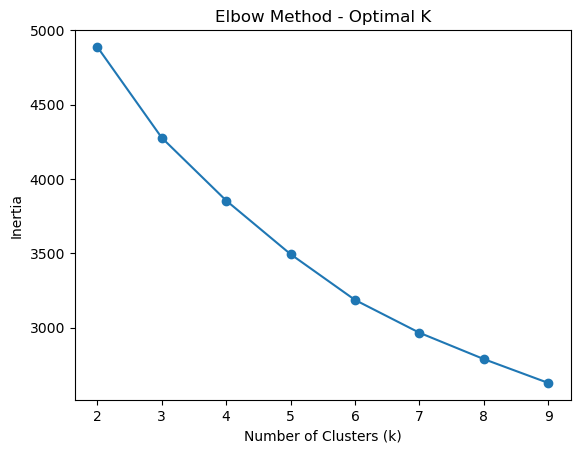

In [55]:
# Choosing k value with Elbow method
# List to store inertia values for different K
inertias = []
# Range of K values to try
K = range(2, 10)

# Run KMeans for each K and store the inertia
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, algorithm='elkan')
    kmeans.fit(scaled_data)
    inertias.append(kmeans.inertia_)  

# Plot the Elbow Method graph to help select the optimal K
plt.plot(K, inertias, marker='o')
plt.title('Elbow Method - Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [87]:
# K Means clustering

# Number of clusters (chosen based on the Elbow Method)
k = 4  

# Apply K-Means clustering
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, algorithm='elkan')
# Predict cluster labels
labels_kmeans = kmeans.fit_predict(scaled_data)
# Add cluster labels to the DataFrame
df['cluster_kmeans'] = labels_kmeans
# Calculate validation metrics
sil_kmeans = silhouette_score(scaled_data, labels_kmeans)  
db_kmeans = davies_bouldin_score(scaled_data, labels_kmeans)   

# Display results
print(f"K-Means - Silhouette Score: {sil_kmeans:.3f}")
print(f"K-Means - Davies-Bouldin Index: {db_kmeans:.3f}")
cluster_counts = df['cluster_kmeans'].value_counts().sort_index()
print("\nNumber of records per cluster:")
print(cluster_counts)

K-Means - Silhouette Score: 0.162
K-Means - Davies-Bouldin Index: 1.816

Number of records per cluster:
cluster_kmeans
0    326
1    265
2    258
3    116
Name: count, dtype: int64


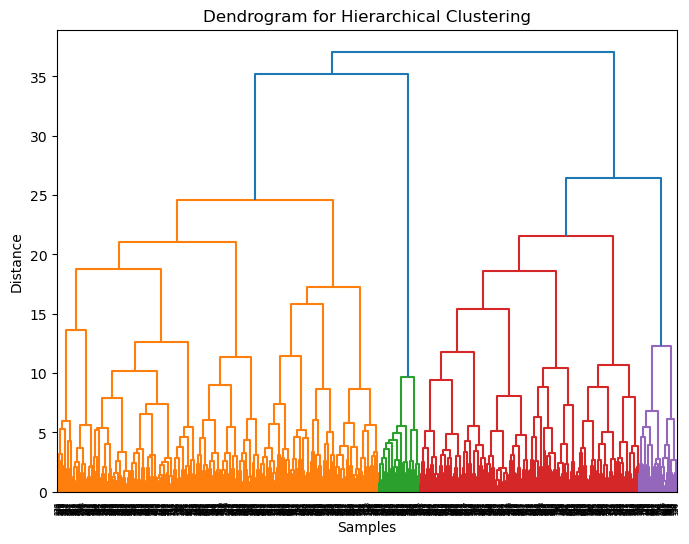

In [88]:
# Dendrogram : Create linkage matrix using Ward method
linked = linkage(scaled_data, method='ward')

# Plot dendrogram
plt.figure(figsize=(8,6))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

In [58]:
# Hierarchical Clustering

# Perform Hierarchical Clustering with 3 clusters based on dendrogram
hier = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_hier = hier.fit_predict(scaled_data)

# Add cluster labels to the DataFrame
df['cluster_hierarchical'] = labels_hier

# Calculate validation metrics to evaluate clustering performance
sil_hier = silhouette_score(scaled_data, labels_hier)  
db_hier = davies_bouldin_score(scaled_data, labels_hier) 

# Display the results of evaluation metrics
print(f"Hierarchical - Silhouette Score: {sil_hier:.3f}")
print(f"Hierarchical - Davies-Bouldin Index: {db_hier:.3f}")
cluster_counts = df['cluster_hierarchical'].value_counts().sort_index()
print("\nNumber of records per cluster:")
print(cluster_counts)

Hierarchical - Silhouette Score: 0.152
Hierarchical - Davies-Bouldin Index: 1.958

Number of records per cluster:
cluster_hierarchical
0    400
1    500
2     65
Name: count, dtype: int64


In [89]:
# DBSCAN clustering 

# Perform DBSCAN clustering 
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(scaled_data)

# Add the clustering results to the DataFrame
df['cluster_dbscan'] = labels_dbscan

# Create a mask to filter out noise points labeled as -1
mask = labels_dbscan != -1  

# If there are non-noise points, calculate clustering evaluation metrics
if mask.sum() > 0:
    sil_dbscan = silhouette_score(scaled_data[mask], labels_dbscan[mask])
    db_dbscan = davies_bouldin_score(scaled_data[mask], labels_dbscan[mask])
    
    print(f"DBSCAN - Silhouette Score: {sil_dbscan:.3f}")
    print(f"DBSCAN - Davies-Bouldin Index: {db_dbscan:.3f}")
else:
    # If all data points are considered noise by DBSCAN
    print("DBSCAN detected only noise; no clusters were formed!")
cluster_counts = df['cluster_dbscan'].value_counts().sort_index()
print("\nNumber of records per cluster:")
print(cluster_counts)

DBSCAN - Silhouette Score: 0.531
DBSCAN - Davies-Bouldin Index: 0.656

Number of records per cluster:
cluster_dbscan
-1    932
 0      8
 1      5
 2      8
 3      6
 4      6
Name: count, dtype: int64


In [60]:
# Create a DataFrame to compare clustering models
comparison_df = pd.DataFrame({
    'Model': ['K-Means', 'Hierarchical', 'DBSCAN'],
    'Silhouette Score': [sil_kmeans, sil_hier, sil_dbscan],
    'Davies-Bouldin Index': [db_kmeans, db_hier, db_dbscan]})

# Sort the DataFrame by Silhouette Score (higher is better)
comparison_df = comparison_df.sort_values(by='Silhouette Score', ascending=False).reset_index(drop=True)

# Add a Rank column based on Silhouette Score
comparison_df['Rank'] = comparison_df['Silhouette Score'].rank(ascending=False).astype(int)

# Display the comparison table
print(comparison_df)


          Model  Silhouette Score  Davies-Bouldin Index  Rank
0        DBSCAN          0.531495              0.656177     1
1       K-Means          0.161987              1.816158     2
2  Hierarchical          0.151846              1.958140     3


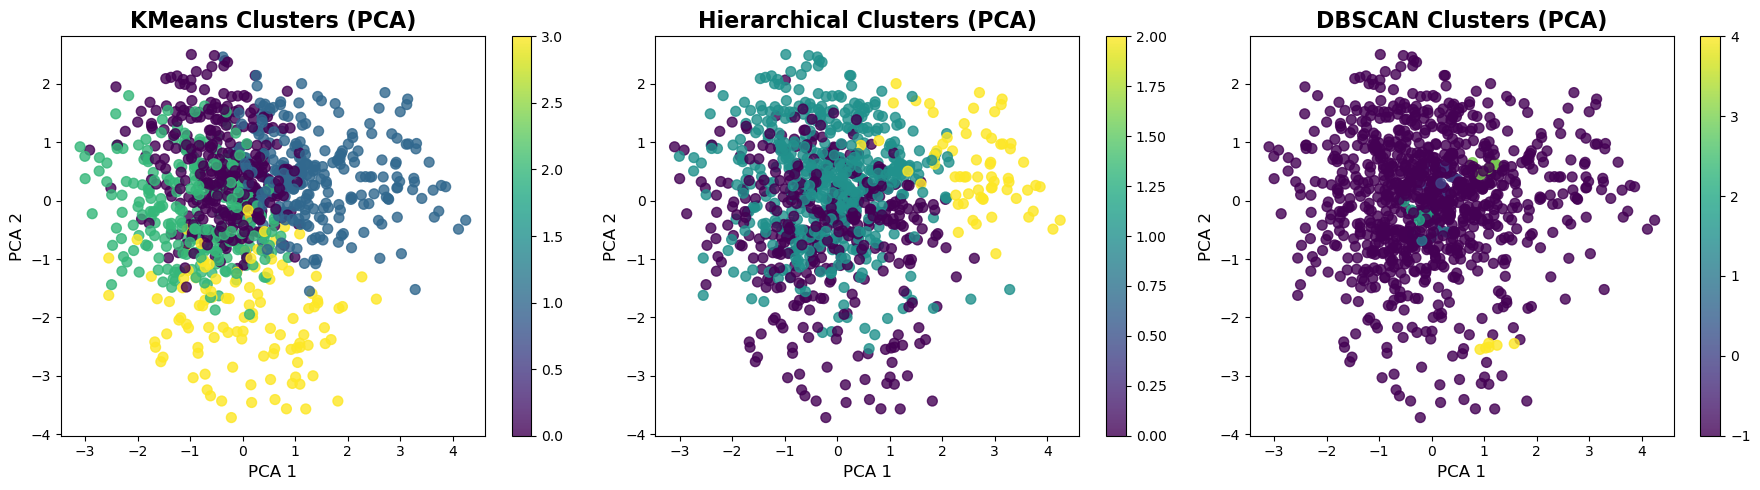

In [61]:
# Cluster Visualization Using PCA

pca = PCA(n_components=2)   
pca_data = pca.fit_transform(scaled_df)

methods = {'KMeans': labels_kmeans,'Hierarchical': labels_hier,'DBSCAN': labels_dbscan}

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, lbl) in zip(axes, methods.items()):
    scatter = ax.scatter(pca_data[:, 0], pca_data[:, 1], c=lbl, s=50, alpha=0.8)
    
    # title
    ax.set_title(f'{name} Clusters (PCA)', fontsize=16, fontweight='bold')
    ax.set_xlabel('PCA 1', fontsize=12)
    ax.set_ylabel('PCA 2', fontsize=12)

    # Add colorbar
    plt.colorbar(scatter, ax=ax)

# Adjust layout
plt.tight_layout()
plt.show()

In [62]:
# K-Means Cluster Summary

cluster_summary = df.groupby('cluster_kmeans').agg({
    'log_price': 'mean',
    'log_available': 'mean',
    'log_sold': 'mean',
    'type_Group': lambda x: x.mode()[0],   
    'brand': lambda x: x.mode()[0],        
    'itemLocation': lambda x: x.mode()[0]  
}).reset_index()

# Convert log values back to original scale
cluster_summary['avg_price'] = np.exp(cluster_summary['log_price']).round(2)
cluster_summary['avg_available'] = np.exp(cluster_summary['log_available']).round(0)
cluster_summary['avg_sold'] = np.exp(cluster_summary['log_sold']).round(0)

# Select and reorder columns for display
final_table = cluster_summary[['cluster_kmeans', 'avg_price', 'avg_available', 'avg_sold', 
                               'type_Group', 'brand', 'itemLocation']]

# Display a styled table
final_table.style.set_caption("K-Means Cluster Summary")\
                 .background_gradient(subset=['avg_price', 'avg_sold'], cmap='Greens')\
                 .format({'avg_price': "${:.2f}", 'avg_available': "{:.0f}", 'avg_sold': "{:.0f}"})


,cluster_kmeans,avg_price,avg_available,avg_sold,type_Group,brand,itemLocation
0,0,$43.55,6,26,medium light,paco rabanne,"brooklyn, new york, united states"
1,1,$32.70,14,712,medium light,armaf,"dallas, texas, united states"
2,2,$41.49,7,23,medium-high,giorgio armani,"miami, florida, united states"
3,3,$31.20,8,42,high,unbranded,"houston, texas, united states"
